# Package

In [1]:
#Torch related package
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchviz
from torch.utils import data

In [2]:
#cuda related package
import torch.cuda
import torch.backends.cudnn as cudnn
print(torch.backends.cudnn.version())

6021


In [3]:
# Other package
import time
import random
from ggplot import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import csv
import os
from PIL import Image
import seaborn as sns; sns.set()


/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/tanguy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
%run GridNet_structure.ipynb #Good trick to launch another notebook
%run Plot.ipynb 
%run Save_import.ipynb
%run Loss_Error.ipynb
%run Label.ipynb


# Commentaire pour la suite (TODO)

On peut enlever le biais dans les convolutions avant la normalisation

Le diminution de la taille des images, pas clair cette division par deux....

Change la fonction de cout, lien entre fonction de cout et de perte ?


Il faut enlever les biais quand il y a une batch normalisation apres

Vérifier ce qu'est la mesure de test IoU

Mettre des commentaire

Ne pas sauvgarder n'importe quand le réseau. Peut ere garder un truc qui a en mémoire le meilleur IuO sur 
la validation

Quel modification sont a faire sur les données ? genre pour les augmenter

Parallelisation, comment ca marche ?

COMMENT VERIFIER QUE TOUT FONCTIONNE ??? Regarder le graph peut être.
Regarder le temps de calcul quand 

Idée: reregarder comment on fait de la segmentation avec les champs de Markov, ca peut donner des idées

Afficher le nom de la courbe avec la courbe et pas juste a coter


Indice qui indique si une fonction est dérivable informatiquement, et prendre uen fonction qui se rapproche de l'IoU

Corrélation entre IoU et le logsoftmax

distance entre deux fonctions ?



# Code

In [6]:
class Parameters():
    def __init__(self,
                 # Number of columns of the grid
                 nColumns = 2,
                 # Number of features map at each rows
                 nFeatMaps = [3,6],
                 # Number of feature map of the input image
                 nFeatureMaps_init = 3,
                 #Number of classes (19(usefull classes) + 1(all other classes together))
                 number_classes = 20,
                 # DataFrame with the name of each label associated with their number
                 label_DF = None,

                 # Size of initial image
                 width_image_initial = 2048, height_image_initial = 1024,
                 # Size after the crop
                 width_image_crop = 19, height_image_crop = 19,

                 # Probability of a Blockwise dropout
                 dropFactor = 0.1,
                 learning_rate=0.01,
                 weight_decay = 5*10**(-6),
                 #Parameter of the Adam Optimizer (beta1 beta2 and epsilon)
                 beta1 = 0.9,
                 beta2 = 0.999,
                 epsilon = 1*10**(-8),
                 # Size of the mini batch
                 batch_size = 2,
                 # Size of the mini batch to compute error (if the entire validation set cannot be in loaded)
                 batch_size_val = 10,
                 # Maximum value of epoch iteration
                 epoch_total = 10,
                 # The actual epoch is not null if we train the network which has already been train
                 actual_epoch = 0,

                 # File where all the parameter model can be store
                 path_save_net = "Model/",
                 #Name of the network, used for store (name_network and train_number)
                 name_network = "test",
                 train_number = 0,
                 # File where the error will be stored
                 path_CSV = "CSV/",
                 # Path of the Data
                 path_data = "/home/tanguy/Documents/Stage de fin d'etude/Cityscapes_Copy",
                 # Number of process that will load the Data
                 num_workers = 0):
        
        super(Parameters, self).__init__()
        # Image
        self.number_classes = number_classes
        self.label_DF = label_DF
        self.width_image_initial = width_image_initial
        self.height_image_initial = height_image_initial
        self.width_image_crop = width_image_crop
        self.height_image_crop = height_image_crop
        # Number of feature map at the begining, if RGB image it would be 3
        self.nFeatureMaps_init = nFeatureMaps_init
        self.path_data = path_data
        
        # GridNet
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.name_network = name_network
        self.train_number = train_number
        self.num_workers = num_workers
        
        #Save
        self.path_CSV = path_CSV
        self.path_save_net = path_save_net
        
        
        # Learning
        self.dropFactor = dropFactor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val
        self.epoch_total = epoch_total
        self.actual_epoch = actual_epoch

In [21]:
"""train return nothing but modify the weight of the network and call save_error to store the error.
    (0) = parameters : list of parameters of the network
    (1) = network : network that will be learned
    (2) = train_loader : Dataloader which contains input and target of the train dataset
    (3) = val_loader : Dataloader which contains input and target of the validation dataset
"""
def train(parameters,network,train_loader,val_loader):
    #Store the time at the begining of the training
    timer_init = time.time()
    
    # create your optimizer
    optimizer = optim.Adam(params = network.parameters(), lr = parameters.learning_rate,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)
    
    #High value just to initialize this variable
    # validation error min will store the lowest validation result
    validation_error_min = 9999
    
    # Store the indice of the next checkpoint. This value is 0 or 1. We always keep one checkpoint untouched
    # while the other one is changed.
    index_save_regular = 0
    index_save_best = 0
    
    
    for epoch in range(parameters.actual_epoch,parameters.epoch_total):
        #Store the time at the begining of each epoch
        timer_epoch = time.time()
        
        for i,(x_batch, y_batch) in enumerate(train_loader):

            # zero the gradient buffers
            optimizer.zero_grad()
            
            #Transform into Variable
            x_batch, y_batch = Variable(x_batch), Variable(y_batch)
            
            # Compute the forward function
            y_batch_estimated = network(x_batch)
            
            #Get the error
            loss = criterion(y_batch_estimated, y_batch)
            
            #Compute the backward function
            loss.backward()
            
            # Does the update according to the optimizer define above
            optimizer.step()
            #Save error of the training Dataset
            save_error(x = x_batch,y = y_batch, network = network,epoch = epoch,name_network = parameters.name_network,
                       train_number = parameters.train_number,path_CSV = parameters.path_CSV,set_type = "train")

        # Validation_error contains the error on the validation set
        validation_error = 0
        
        # Save the error of the validation Dataset
        for i,(x_val_batch, y_val_batch) in enumerate(val_loader):
            x_val_batch, y_val_batch = Variable(x_val_batch), Variable(y_val_batch)
            validation_error += save_error(x = x_val_batch,y = y_val_batch,network = network,epoch = epoch,
                                          name_network = parameters.name_network, train_number = parameters.train_number,
                                          path_CSV = parameters.path_CSV, set_type = "validation")
        
        # Divise by the the number of element in the entire batch
        validation_error = validation_error/((i+1)*parameters.batch_size_val)
        
        # checkpoint will save the network if needed
        validation_error_min,index_save_best,index_save_regular = checkpoint(validation_error,validation_error_min,
                                                                               index_save_best,index_save_regular,
                                                                               epoch,network,parameters)
                    
        
        print("Epoch :",epoch,"/",parameters.epoch_total - 1,". Last loss : ",loss.data[0],
              ". Time Epoch :", time.time() - timer_epoch,". Time total", time.time() - timer_init)

    print("Finish. Total mean time : ", (time.time() - timer_init)/(parameters.epoch_total- parameters.actual_epoch))
    
    return()

In [24]:
label_name = {'Real_name' : ["road","sidewalk","building","wall","fence","pole","traffic light","traffic sign",
                             "vegetation","terrain","sky","person","rider","car","truck","bus","train","motorcycle",
                             "bicycle","autre"],
              'Class_name' : ["class"+str(i) for i in range(19)] + ["class19"]}

label_DF = pd.DataFrame(data=label_name)
 
%run GridNet_structure.ipynb #Good trick to launch another notebook
%run Plot.ipynb 
%run Save_import.ipynb
%run Loss_Error.ipynb
%run Label.ipynb
parameters = Parameters(nColumns = 2,
                            nFeatMaps = [3,6],
                            nFeatureMaps_init = 3,
                            number_classes = 20-1,
                            label_DF = label_DF,

                            width_image_initial = 2048, height_image_initial = 1024,
                            width_image_crop = 3, height_image_crop = 19,

                            dropFactor = 0.1,
                            learning_rate=0.01,
                            weight_decay = 5*10**(-6),
                            beta1 = 0.9,
                            beta2 = 0.999,
                            epsilon = 1*10**(-8),
                            batch_size = 1,
                            batch_size_val = 10,
                            epoch_total = 1,
                            actual_epoch = 0,

                            path_save_net = "Model/",
                            name_network = "test",
                            train_number = 0,
                            path_CSV = "CSV/",
                            path_data = "/home/tanguy/Documents/Cityscapes_Copy",
                            num_workers = 0)


In [25]:
def main_new_learning():
    
    #Transformation that will be apply on the data just after the import
    transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor(),
    ])

    target_transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor()
    ])
    
    #Import both dataset with the transformation
    train_dataset = CityScapes_final('fine', 'train',transform = transform, target_transform = target_transform)
    val_dataset = CityScapes_final('fine', 'val',transform = transform, target_transform = transform)

    # Creat the DataSet for pytorch used
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters.batch_size, shuffle=True,
                                               num_workers=parameters.num_workers,drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=parameters.batch_size_val, shuffle = True,
                                             num_workers=parameters.num_workers,drop_last=True)
    
    # Define the GridNet
    network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes,
                      nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)

    #Init the csv file that will store the error
    init_csv(name_network = parameters.name_network, train_number = parameters.train_number,
             path_CSV = parameters.path_CSV)

    #Train the network
    train(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)

    
main_new_learning()

TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !
The network as been saved at the epoch 0(best score)0
Epoch : 0 / 0 . Last loss :  2.8551855087280273 . Time Epoch : 2.7001399993896484 . Time total 2.7004871368408203
Finish. Total mean time :  2.701357364654541


In [135]:
def main_continue_learning():

    #Transformation that will be apply on the data just after the import
    transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor(),
    ])

    target_transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor()
    ])
    
    #Import both dataset with the transformation
    train_dataset = CityScapes_final('fine', 'train',transform = transform, target_transform = target_transform)
    val_dataset = CityScapes_final('fine', 'val',transform = transform, target_transform = target_transform)

    # Creat the DataSet for pytorch used
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters.batch_size, shuffle=True,
                                               num_workers=parameters.num_workers,drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=parameters.batch_size_val, shuffle = True,
                                             num_workers=parameters.num_workers,drop_last=True)
    
    # Define the GridNet
    network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes,
                      nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)
    
    # Load the trained Network
    parameters = load_from_checkpoint(path_checkpoint = parameters.path_save_net + "best1test0checkpoint.pth.tar",
                                      network = network)
    
    # Here we can change some parameters
    parameters.epoch_total = 15
    
    # Train the network
    train(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)

    
main_continue_learning()

=> loading checkpoint 'Model/best1test0checkpoint.pth.tar'


RuntimeError: While copying the parameter named lastConv.conv1.weight, whose dimensions in the model are torch.Size([19, 3, 3, 3]) and whose dimensions in the checkpoint are torch.Size([20, 3, 3, 3]).

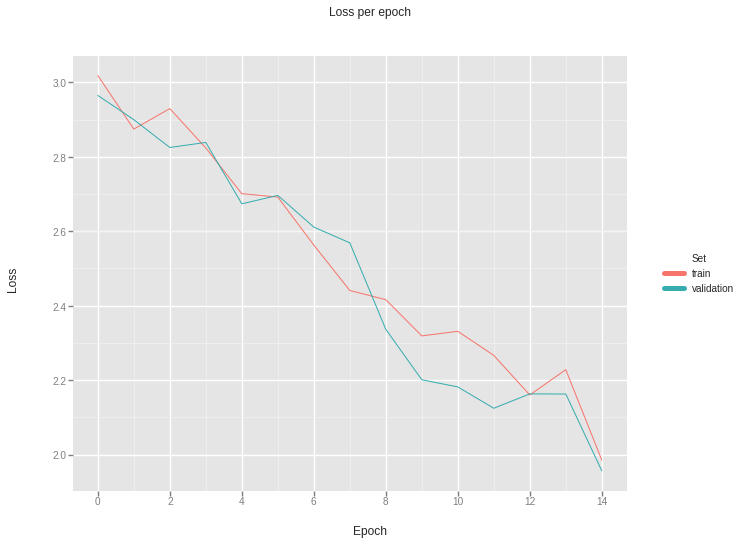

<ggplot: (-9223363292985193030)>


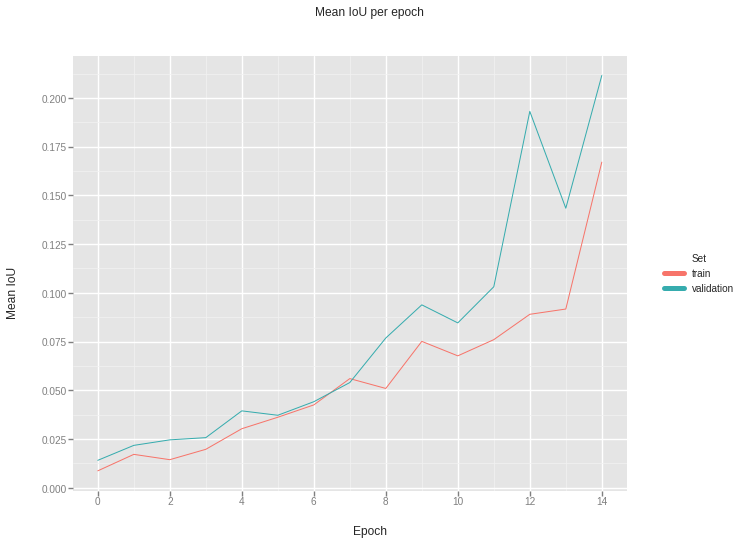

<ggplot: (-9223363292972276834)>


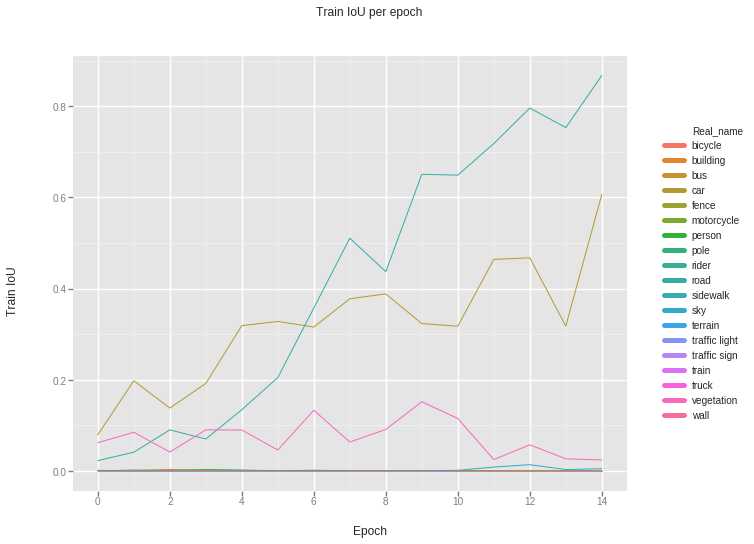

<ggplot: (-9223363292935947583)>


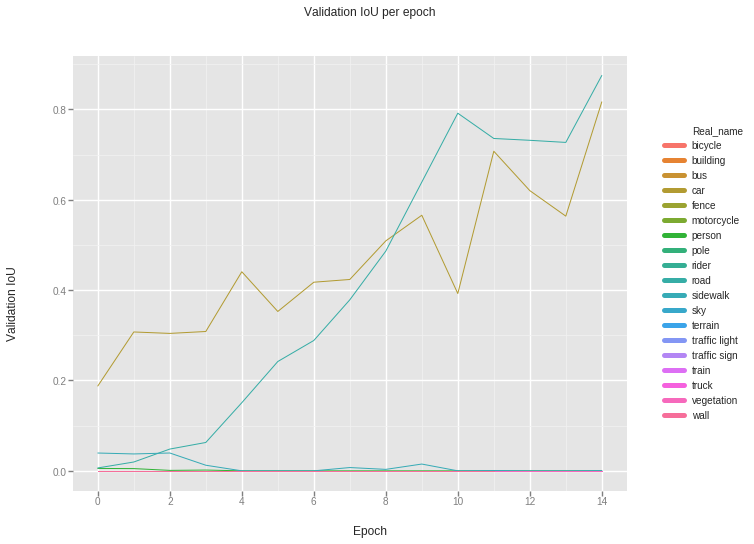

<ggplot: (8743916040950)>


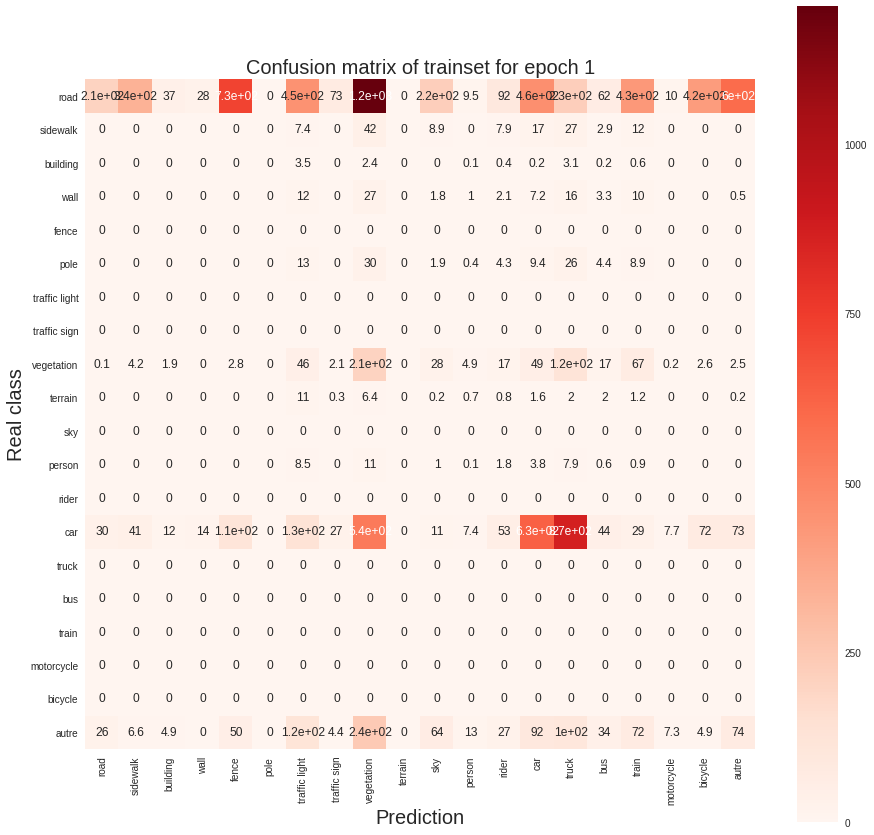

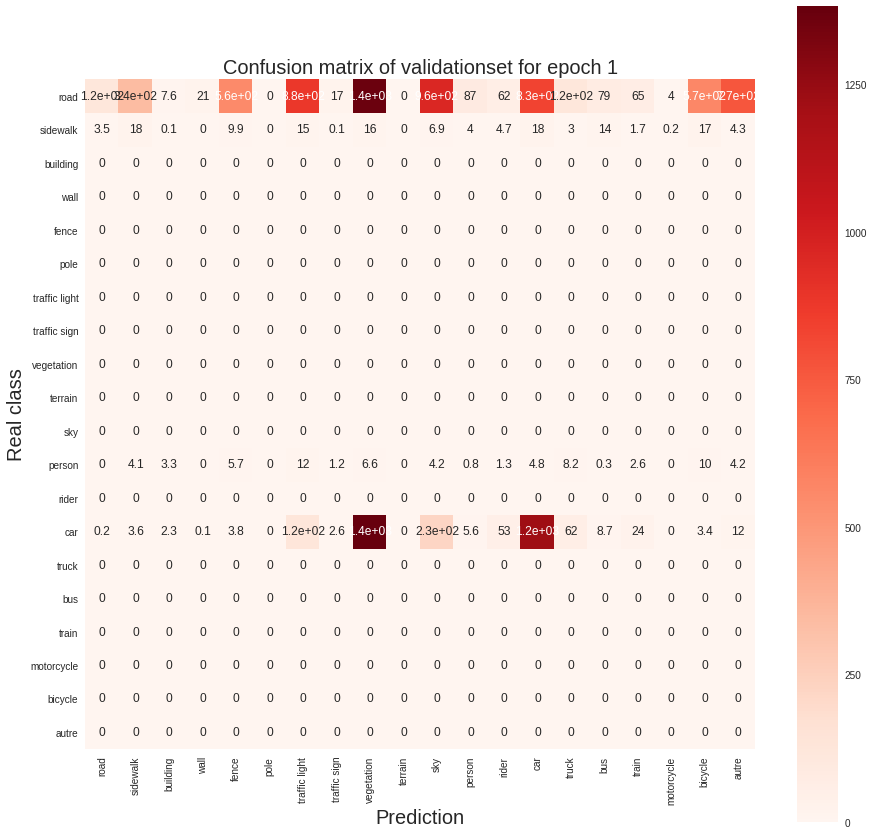

In [134]:
#Because we work with mini batch, there is an error for each mini_batch. Organise CSV take the mean of those error.
organise_CSV(name_network = parameters.name_network,train_number = parameters.train_number)

plot_loss(name_network = parameters.name_network,train_number = parameters.train_number)

plot_IuO(name_network = parameters.name_network,train_number = parameters.train_number)

plot_mat_confusion(name_network = parameters.name_network, train_number = parameters.train_number,
                   epoch = parameters.epoch_total - 1, data_set = "train")

plot_mat_confusion(name_network = parameters.name_network, train_number = parameters.train_number,
                   epoch = parameters.epoch_total - 1,data_set = "validation")
